# Modelling a resistive casing - magnetic dipole source

This example examines a frequency-domain EM experiment in a resistive casing. We use SimPEG to run the forward simulations on a cylindrically symmetric mesh. For more background, on modelling casings with SimPEG, please see:

- Heagy, L. J., & Oldenburg, D. W. (2018). Modeling electromagnetics on cylindrical meshes with applications to steel-cased wells. Computers & geosciences. [https://doi.org/10.1016/j.cageo.2018.11.010](https://doi.org/10.1016/j.cageo.2018.11.010)


In order to run each cell, you can use `shift`+`enter`. If you are looking for more resources on getting started with Jupyter and with Python, I highly recommend:
- [A Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/)
- [The Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/)

In [1]:
# core python
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot
import os
import ipywidgets
import time
from string import ascii_lowercase
from matplotlib import rcParams
from matplotlib import gridspec

# SimPEG, discretize
import discretize
from discretize import utils
from SimPEG.electromagnetics import frequency_domain as fdem
from SimPEG import maps, utils
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casing_sim

%matplotlib inline

In [2]:
from matplotlib import rcParams
rcParams["font.size"] = 14

## Model parameters

The following cell states the model parameters - all in SI units
- conductivities [$S/m$]
- lengths / diameter / radius [$m$]
- frequencies [$Hz$]

The coordinate system is right-handed with z-positive up. Depths are converted to z by multiplying by -1. 

Note that there should be no contrasts that are larger than ~1e10 S/m in the model. Larger contrasts risk introducing numerical errors. (This is very important for conductive casings, but still worth noting here) 

### Casing parameters

In [3]:
# conductivities (all in S/m)
sigma_air = 1e-8 
sigma_back = 1e-2
sigma_casing = 1e-10
sigma_inside = 1 

# casing geometry (all in meters)
casing_diameter = 10e-2  # outer diameter of the casing
casing_t = 10e-3  # thickness of the casing wall
casing_l = 1000  # length of the casing

### Source parameters

z is positive up, so we specify negative values for the source location to have it be downhole

In [4]:
src_z = -505

frequencies = [100, 300, 1000] 

### convienience tools

The following sets up an object to keep track of the model parameters. You shouldn't need to change anything here. 

In [5]:
model = casing_sim.model.CasingInHalfspace(
    casing_d = casing_diameter - casing_t,  # I use diameter to the center of the casing wall
    casing_l = casing_l,
    casing_t = casing_t, 
    sigma_air = sigma_air,
    sigma_casing = sigma_casing,
    sigma_back = sigma_back,
    sigma_inside = sigma_inside,
    src_a = np.r_[0., 0., src_z],
    src_b = np.r_[0., 0., src_z],
    freqs = np.array(frequencies, dtype=float)
)

Compute the skin depths of the models to design a sensible mesh

In [6]:
print(model.skin_depth())

[503.29212104 290.57584157 159.15494309]


## Mesh

Here we set up a cylindrically symmetric mesh. The mesh generator tool creates a mesh which discretizes the casing quite finely - there are 4 cells across the width of the casing thickness. 

You can set the parameters in the cell below depending on where you want to look at data and how finely it needs to sampled. 
- `cell_hx` is the width of cells in the region of the mesh away from the well where we want to measure data. 
- `cell_hz` is the vertical extent of the cells along the length of the casing
- `domain_x` is the total extent of the region where we we are examining the fields and fluxes, outside of this, we use padding cells in order to satisfy boundary conditions
- `npad_x` is the number of x padding cells
- `npad_z` is the number of z padding cells

The padding cells should ensure that the mesh goes at least one skin depth out, preferably 2. 

In [7]:
cell_hx = 50
cell_hz = 2.5
domain_x = 1000

npad_x = 10
npad_z = 20

In [8]:
mesh_generator = casing_sim.mesh.CasingMeshGenerator(
    modelParameters = model, 
    csx1 = model.casing_t/4,
    csx2 = cell_hx,
    domain_x = domain_x,
    npadx = 8, 
    npadz = 17, 
    csz = cell_hz,
)

In [9]:
mesh = mesh_generator.mesh
print(
    f"The mesh has {mesh.nC} cells \n"
    f" * x-extent: {mesh.vectorNx[-1]:1.1e} m\n"
    f" * z-extent: [{mesh.vectorNz[0]:1.1e} m, {mesh.vectorNz[-1]:1.1e} m]"
)

The mesh has 38628 cells 
 * x-extent: 4.8e+03 m
 * z-extent: [-8.4e+03 m, 7.4e+03 m]


Plot the mesh. To zoom in, un-comment the lines that set the `xlim` and `ylim`

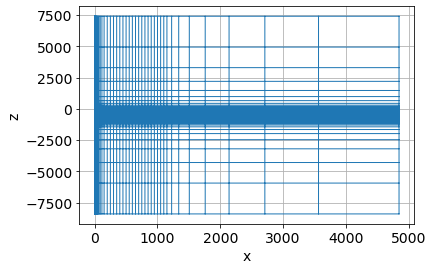

In [10]:
fig, ax = plt.subplots(1,1)
mesh.plotGrid(ax=ax)

# ax.set_xlim([0, 0.1])
# ax.set_ylim([0, -2])

### put the model on the mesh

In [11]:
sigma = model.sigma(mesh)

In [12]:
def add_layer(conductivity, layer_conductivity, layer_z):
    inds = (
        (mesh.gridCC[:, 2] >= layer_z.min()) & (mesh.gridCC[:, 2] <= layer_z.max()) & # vertical extent of the layer
        (~model.ind_casing(mesh) & ~model.ind_inside(mesh))  # outside the casing
    )
    conductivity[inds] = layer_conductivity
    return conductivity

In [13]:
sigma = add_layer(sigma, 1e-1, np.r_[-400, -500])

In [14]:
def plot_conductivity(conductivity, ax=None):
    """
    Plot the conductivity model on the mesh. We format the colorbar to be log-scale 
    and label the axes nicely. 
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    out = mesh.plotImage(conductivity, mirror=True, ax=ax, pcolorOpts={"norm":LogNorm()})
    cb = plt.colorbar(out[0], ax=ax)
    cb.set_label("conductivity (S/m)")
    
    ax.set_title("$\sigma$")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")

(-1400, 10)

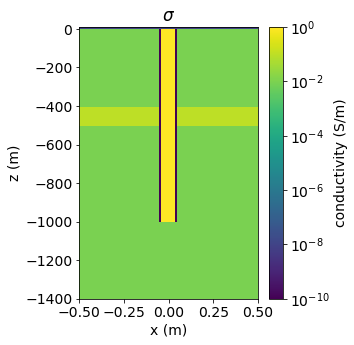

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4, 5))

plot_conductivity(sigma, ax=ax)

xlim = 0.5 * np.r_[-1, 1]
zlim = np.r_[-1400, 10]

ax.set_xlim(xlim)
ax.set_ylim(zlim)

### create another model with a gap in the casing
- gaps should be at least the same size as the cell-size in the z-direction (2.5m) 
- to add more gaps, add more tuples to the list, e.g.
```
gaps = [(-800, -805), (-900, -905)]
```

In [16]:
def create_gaps_model(gaps, sigma_gap=sigma_inside):
    """
    Create a model which has gaps in the casing. 
    
    Paramters
    ---------
    gaps: list(tuples)
        list of the vertical extent of the gaps in the casing. 
        e.g. A model with two gaps, one extending from z0 to z1 
        and a second extending from z2 to z3 would be: 
            gaps = [(z0, z1), (z2, z3)]
    
    sigma_gap: float
        conductivity to put in the gaps. The default fills
        the gaps with the same conductivity as the fluid
        inside of the casing
    """
    
    sigma_gaps = sigma.copy()
    for gap in gaps:
        if len(gap) != 2:
            raise Exception(f"Gaps must be length 2, the provided input {gap} is not")
        gap = np.array(gaps)
        indices_gap = (
            model.ind_casing(mesh) & 
            (mesh.gridCC[:, 2] <= gap.max()) & (mesh.gridCC[:, 2] >= gap.min())
        )

        sigma_gaps[indices_gap] = sigma_gap
    return sigma_gaps

In [17]:
gaps = [(-800, -805)]
sigma_gaps = create_gaps_model(gaps)

In [18]:
# store the conductivity models in a dictionary for simplicity
model_dict = {
    "intact": sigma,
    "gaps": sigma_gaps
}

model_names = list(model_dict.keys())

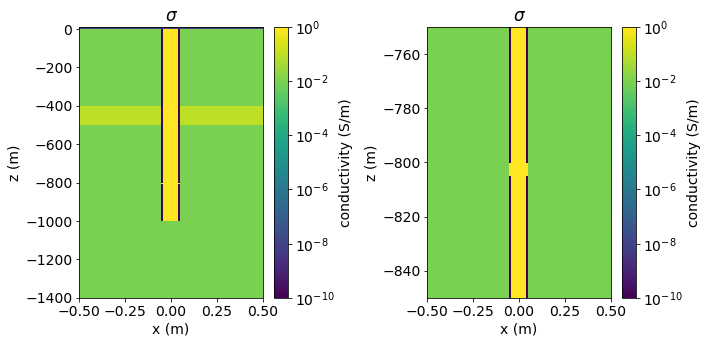

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# full casing
plot_conductivity(sigma_gaps, ax=ax[0])

xlim = 0.5 * np.r_[-1, 1]
zlim = np.r_[-1400, 10]

ax[0].set_xlim(xlim)
ax[0].set_ylim(zlim)

# zoom in to gap
plot_conductivity(sigma_gaps, ax=ax[1])
xlim = 0.5 * np.r_[-1, 1]
zlim = np.r_[-850, -750]

ax[1].set_xlim(xlim)
ax[1].set_ylim(zlim)

plt.tight_layout()

## Set up the simulation

Here, we discretize the magnetic flux density on cell faces and the electric field on edges

### Create the source

In [20]:
source_list = [
    fdem.sources.MagDipole(
        frequency=freq, location=np.r_[0, 0, src_z], orientation="Z",
        # moment=1
    )
    for freq in frequencies
]

### Setup and solve the forward problem

In [21]:
survey = fdem.Survey(source_list)
simulation = fdem.Problem3D_b(
    mesh, sigmaMap=maps.IdentityMap(mesh), Solver=Pardiso,
    survey=survey
)

In [22]:
fields_dict = {}

In [23]:
%%time
for key in model_names:
    t = time.time()
    print(f"solving {key} model")
    fields_dict[key] = simulation.fields(model_dict[key])
    print(f" ... done. Elapsed time: {time.time()-t:1.2e}s\n")

solving intact model
 ... done. Elapsed time: 1.39e+00s

solving gaps model
 ... done. Elapsed time: 1.28e+00s

CPU times: user 8.65 s, sys: 882 ms, total: 9.53 s
Wall time: 2.67 s


## Visualize the results

The following sets up an interactive viewer to visualize the fields and fluxes. The first one zooms in to the casing if you would like to see the behaviour of the fields and fluxes in the immediate vicinity of the casing. The second one zooms out so that you can see the behaviour of the fields and fluxes in the surrounding geologic formation. 

The title of the plot will tell you which model you are view, which field and what frequency. 

**Parameters**
- `max_r`: max radius of the plot (m)
- `min_depth`: minimum depth to plot (-z, in meters)
- `max_depth`: maximum depth to plot (-z, in meters)
- `clim_min`: minimum colorbar value
- `clim_max`: maximum colorbar value
- `model_key`: model to view
- `view`: field you want to visualize
- `prim_sec`: the primary is set to be the intact casing. If you view the "secondary" the response of the intact casing is subtracted off from the model you are visualizing
- `real_or_imag`: real or imaginary component
- `src_ind`: index of the source (move to change the frequency you are viewing)
- `show_mesh`: plots the mesh on the right-hand half of the plot
- `use_aspect`: sets the size of the axes to have an aspect ratio of 1
- `casing_outline`: draws the outline of the casing

In [24]:
viewer = casing_sim.FieldsViewer(
    mesh=mesh, model_parameters_dict={key: model for key in model_names}, 
    survey_dict={key: simulation.survey for key in model_names}, 
    fields_dict=fields_dict, model_keys=model_names, 
    primary_key="intact"
)

In [25]:
out1 = viewer.widget_cross_section(
    defaults={
        "max_depth":1400,
        "min_depth":-10,
        "max_r":0.2,
        "view":"b",
        "casing_outline": False,
        "clim_min": 1e-14,
        "clim_max":1e-9
    }
)
out1

interactive(children=(FloatText(value=0.2, description='max_r'), FloatText(value=-10.0, description='min_depth…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [26]:
viewer.widget_cross_section(
    defaults={
        "max_depth":1.5*model.casing_l,
        "min_depth":-10,
        "max_r":1.5*model.casing_l,
        "view":"b",
        "casing_outline":False,
        "clim_min":1e-16,
        "clim_max":1e-9,
        "use_aspect":True,
    }, 
    figwidth=12
)

interactive(children=(FloatText(value=1500.0, description='max_r'), FloatText(value=-10.0, description='min_de…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

### Plot electric field measurements

In the following two sections, we plot measurements of the electric field along a line. The first set of plots computes the horizontal electric field along the surface, the second set of plots computes the vertical electric field in a borehole. 

#### data at the surface
In the following, we compute the electric field at a constant depth (e.g. if we were to take measurements at the surface) 

In [27]:
def get_e(key, source_ind, component="y"):
    """
    A utility function for fetching one spatial component of the 
    electric field for a single source. 
    
    Parameters
    ----------
    key: string
        The name of the model to fetch. e.g. "intact", "gaps"
    
    source_ind: int
        Index of the source (frequency) that you want
    
    component: string
        spatial component to fetch ("y"). For a magnetic dipole source in a cylindrically symmetric domain, the 
    
    Returns
    -------
    (grid, e): the spatial grid and the electric field on that grid
    """
    
    src = survey.source_list[source_ind]
    e = fields_dict[key][src, 'e']
    grid = mesh.gridEy
        
    return grid, e

In [28]:
def get_e_data_horizontal(key, source_ind=0, component="y", x=[5, 1000], z=-0.1):
    """
    A utility function for fetching the electric field along a constant depth. 
    """
    grid, e = get_e(key, source_ind, component)
    x = np.array(x)
    z = np.array(z)
    x_inds = (grid[:, 0] >= x.min()) & (grid[:, 0] <= x.max())
    z_inds = np.abs(grid[:, 2] - z) == np.min(np.abs(grid[:, 2] - z))
    inds = x_inds & z_inds
    
    return grid[inds, 0], utils.mkvc(e[inds])
    

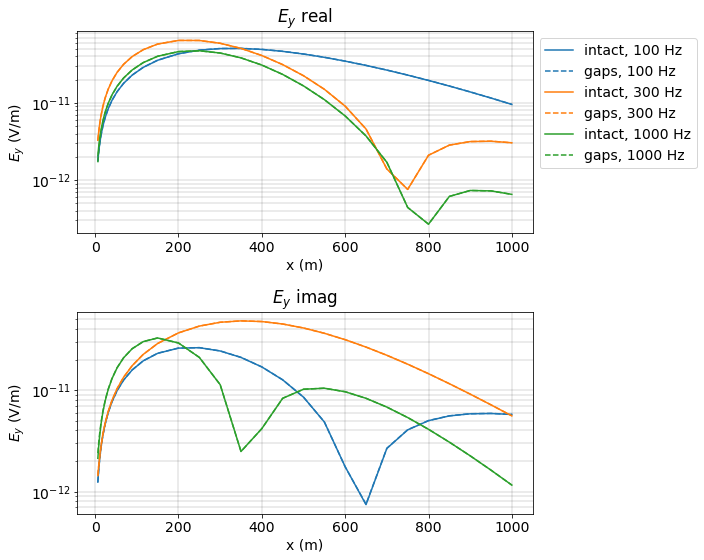

In [29]:
x_horizontal = [5, 1000]
z_horizontal = 0.
component = "y"

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

for i, freq in enumerate(frequencies):
    for key, ls in zip(model_names, ["-", "--"]):  
        x_axis, e = get_e_data_horizontal(key, source_ind=i, component=component)
        label=f"{key}, {freq} Hz"
        ax[0].semilogy(x_axis, np.abs(e.real), color=f"C{i}", ls=ls, label=label)
        ax[1].semilogy(x_axis, np.abs(e.imag), color=f"C{i}", ls=ls, label=label)

for a in ax:
    a.set_xlabel("x (m)")
    a.grid(which="both", color="k", alpha=0.4, lw=0.4)
    a.set_ylabel(f"$E_{component}$ (V/m)")

ax[0].set_title(f"$E_{component}$ real")
ax[1].set_title(f"$E_{component}$ imag")
ax[0].legend(bbox_to_anchor=[1, 1])

# ax[0].set_ylim([1e-9, 1e-5])
# ax[1].set_ylim([1e-9, 1e-5])

plt.tight_layout()


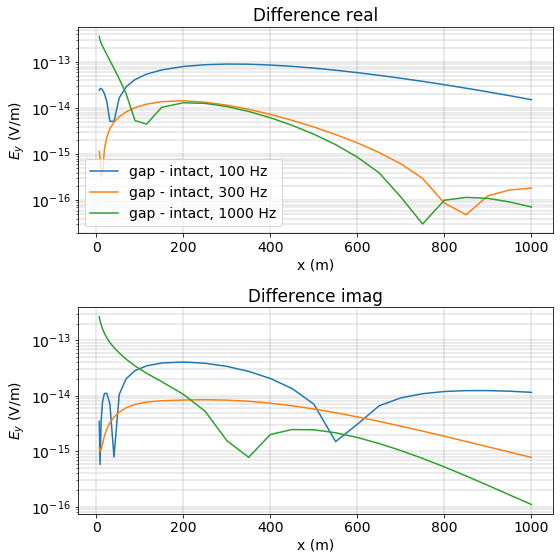

In [30]:
x_horizontal = [5, 1000]
z_horizontal = 0.
component = "y"

fig, ax = plt.subplots(2, 1, figsize=(8, 8))

for i, freq in enumerate(frequencies):
    x_axis, eintact = get_e_data_horizontal("intact", source_ind=i, component=component)
    x_axis, egap = get_e_data_horizontal("gaps", source_ind=i, component=component)
    e = eintact-egap
    label=f"gap - intact, {freq} Hz"
    ax[0].semilogy(x_axis, np.abs(e.real), color=f"C{i}", label=label)
    ax[1].semilogy(x_axis, np.abs(e.imag), color=f"C{i}", label=label)

for a in ax:
    a.set_xlabel("x (m)")
    a.grid(which="both", color="k", alpha=0.4, lw=0.4)
    a.set_ylabel(f"$E_{component}$ (V/m)")

ax[0].set_title("Difference real")
ax[1].set_title("Difference imag")
ax[0].legend()

# ax[0].set_ylim([1e-10, 1e-6])
# ax[1].set_ylim([1e-10, 1e-7])

plt.tight_layout()


#### data in a borehole
In the following, we compute the electric field at a constant depth (e.g. if we were to take measurements at the surface) 

In [31]:
def get_e_data_borehole(key, source_ind=0, component="y", x=100, z=[-1000, 0]):
    """
    A utility function for fetching the electric field at a constant radius. 
    """
    
    grid, e = get_e(key, source_ind, component)
    
    x = np.array(x)
    z = np.array(z)
    
    x_inds = np.abs(grid[:, 0] - x) == np.min(np.abs(grid[:, 0] - x))
    z_inds = (grid[:, 2] >= z.min()) & (grid[:, 2] <= z.max())
    
    inds = x_inds & z_inds
    
    return grid[inds, 2], utils.mkvc(e[inds])
    

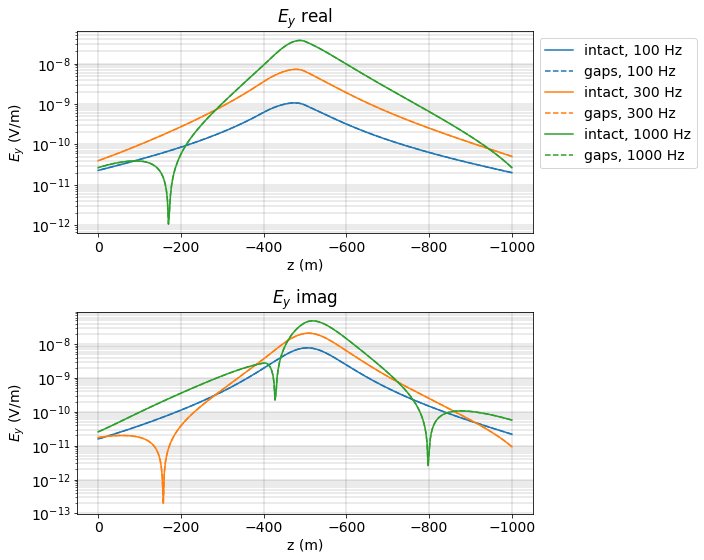

In [32]:
x_borehole = 100
z_borehole = [-1000, 0]
component = "y"

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

for i, freq in enumerate(frequencies):
    for key, ls in zip(model_names, ["-", "--"]):  
        x_axis, e = get_e_data_borehole(key, source_ind=i, component=component)
        label=f"{key}, {freq} Hz"
        ax[0].semilogy(x_axis, np.abs(e.real), color=f"C{i}", ls=ls, label=label)
        ax[1].semilogy(x_axis, np.abs(e.imag), color=f"C{i}", ls=ls, label=label)

for a in ax:
    a.set_xlabel("z (m)")
    a.grid(which="both", color="k", alpha=0.4, lw=0.4)
    a.set_ylabel(f"$E_{component}$ (V/m)")
    a.set_xlim(a.get_xlim()[::-1])

ax[0].set_title(f"$E_{component}$ real")
ax[1].set_title(f"$E_{component}$ imag")
ax[0].legend(bbox_to_anchor=[1, 1])

# ax[0].set_ylim([1e-8, 1e-5])
# ax[1].set_ylim([1e-8, 1e-5])

plt.tight_layout()


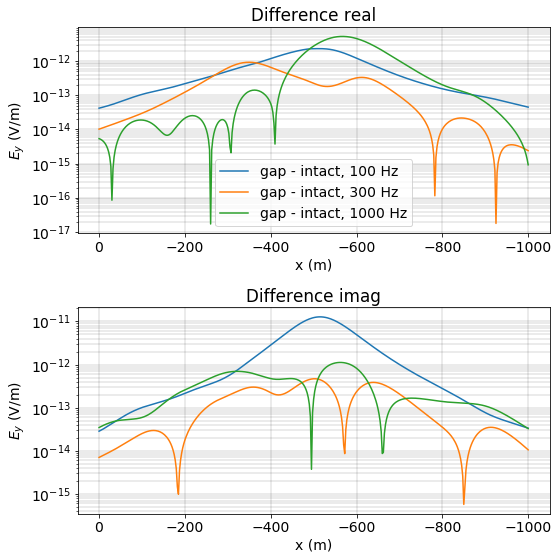

In [33]:
x_borehole = 100
z_borehole = [-1000, 0]
component = "y"

fig, ax = plt.subplots(2, 1, figsize=(8, 8))

for i, freq in enumerate(frequencies):
    x_axis, eintact = get_e_data_borehole("intact", source_ind=i, component=component)
    x_axis, egap = get_e_data_borehole("gaps", source_ind=i, component=component)
    e = eintact-egap
    label=f"gap - intact, {freq} Hz"
    ax[0].semilogy(x_axis, np.abs(e.real), color=f"C{i}", label=label)
    ax[1].semilogy(x_axis, np.abs(e.imag), color=f"C{i}", label=label)

for a in ax:
    a.set_xlabel("x (m)")
    a.grid(which="both", color="k", alpha=0.4, lw=0.4)
    a.set_ylabel(f"$E_{component}$ (V/m)")
    a.set_xlim(a.get_xlim()[::-1])

ax[0].set_title("Difference real")
ax[1].set_title("Difference imag")
ax[0].legend()

# ax[0].set_ylim([1e-8, 1e-5])
# ax[1].set_ylim([1e-10, 1e-5])

plt.tight_layout()


In [34]:
def get_b(key, source_ind, component, field_opt="total"):
    """
    A utility function for fetching one spatial component of the 
    electric field for a single source. 
    
    Parameters
    ----------
    key: string
        The name of the model to fetch. e.g. "intact", "gaps"
    
    source_ind: int
        Index of the source (frequency) that you want
    
    component: string
        spatial component to fetch ("x", "z")
    
    field_opt: string
        "total" or "secondary" - the field to grab
    
    Returns
    -------
    (grid, b): the spatial grid and the electric field on that grid
    """
    
    src = survey.source_list[source_ind]
    
    if field_opt.lower() == "total":
        b = fields_dict[key][src, 'b']
    elif field_opt.lower() == "secondary":
        b = fields_dict[key][src, 'bSecondary']
    
    if component.lower() == "x":
        b = b[:mesh.nFx]
        grid = mesh.gridFx
        
    elif component.lower() == "z":
        b = b[mesh.nFx:]
        grid = mesh.gridFz
        
        
    return grid, b

In [35]:
def get_b_data_horizontal(key, source_ind=0, component="x", field_opt="total", x=[5, 1000], z=-0.1):
    """
    A utility function for fetching the magnetic flux along a constant depth. 
    """
    grid, b = get_b(key, source_ind, component, field_opt)
    x = np.array(x)
    z = np.array(z)
    x_inds = (grid[:, 0] >= x.min()) & (grid[:, 0] <= x.max())
    z_inds = np.abs(grid[:, 2] - z) == np.min(np.abs(grid[:, 2] - z))
    inds = x_inds & z_inds
    
    return grid[inds, 0], utils.mkvc(b[inds])
    

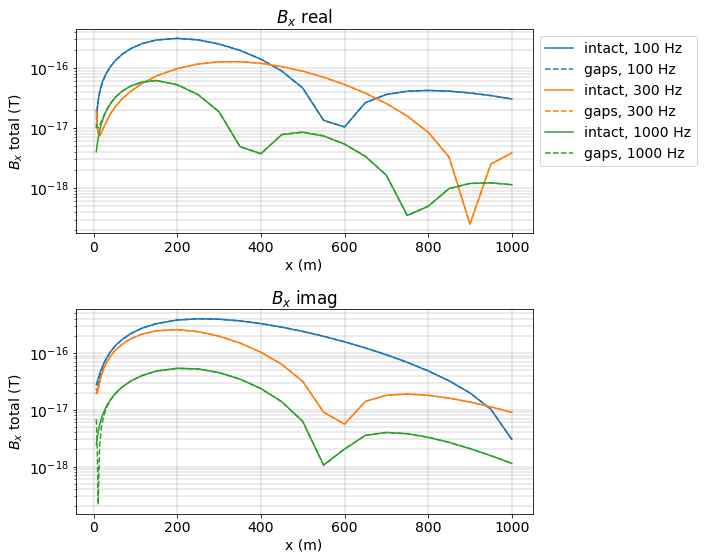

In [36]:
x_horizontal = [5, 1000]
z_horizontal = 0.
component = "x"
field_opt = "total"  # or "secondary"

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

for i, freq in enumerate(frequencies):
    for key, ls in zip(model_names, ["-", "--"]):  
        x_axis, b = get_b_data_horizontal(
            key, source_ind=i, component=component, field_opt=field_opt
        )
        label=f"{key}, {freq} Hz"
        ax[0].semilogy(x_axis, np.abs(b.real), color=f"C{i}", ls=ls, label=label)
        ax[1].semilogy(x_axis, np.abs(b.imag), color=f"C{i}", ls=ls, label=label)

for a in ax:
    a.set_xlabel("x (m)")
    a.grid(which="both", color="k", alpha=0.4, lw=0.4)
    a.set_ylabel(f"$B_{component}$ {field_opt} (T)")

ax[0].set_title(f"$B_{component}$ real")
ax[1].set_title(f"$B_{component}$ imag")
ax[0].legend(bbox_to_anchor=[1, 1])

# ax[0].set_ylim([1e-9, 1e-5])
# ax[1].set_ylim([1e-9, 1e-5])

plt.tight_layout()


In [37]:
def get_b_data_borehole(key, source_ind=0, component="z", field_opt="total", x=100, z=[-1000, 0]):
    """
    A utility function for fetching the magnetic flux at a constant radius. 
    """
    
    grid, b = get_b(key, source_ind, component, field_opt)
    
    x = np.array(x)
    z = np.array(z)
    
    x_inds = np.abs(grid[:, 0] - x) == np.min(np.abs(grid[:, 0] - x))
    z_inds = (grid[:, 2] >= z.min()) & (grid[:, 2] <= z.max())
    
    inds = x_inds & z_inds
    
    return grid[inds, 2], utils.mkvc(b[inds])
    

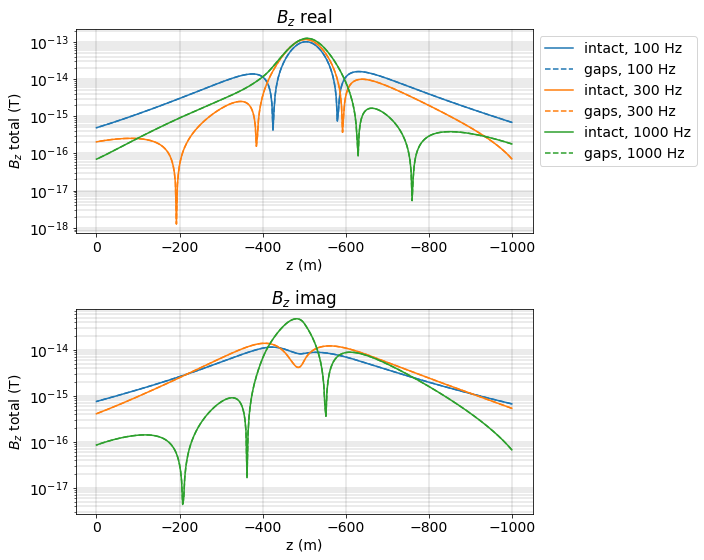

In [38]:
x_borehole = 100
z_borehole = [-1000, 0]
component = "z"
field_opt = "total"  # or secondary

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

for i, freq in enumerate(frequencies):
    for key, ls in zip(model_names, ["-", "--"]):  
        x_axis, b = get_b_data_borehole(
            key, source_ind=i, component=component, field_opt=field_opt
        )
        label=f"{key}, {freq} Hz"
        ax[0].semilogy(x_axis, np.abs(b.real), color=f"C{i}", ls=ls, label=label)
        ax[1].semilogy(x_axis, np.abs(b.imag), color=f"C{i}", ls=ls, label=label)

for a in ax:
    a.set_xlabel("z (m)")
    a.grid(which="both", color="k", alpha=0.4, lw=0.4)
    a.set_ylabel(f"$B_{component}$ {field_opt} (T)")
    a.set_xlim(a.get_xlim()[::-1])

ax[0].set_title(f"$B_{component}$ real")
ax[1].set_title(f"$B_{component}$ imag")
ax[0].legend(bbox_to_anchor=[1, 1])

# ax[0].set_ylim([1e-8, 1e-5])
# ax[1].set_ylim([1e-8, 1e-5])

plt.tight_layout()
